In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [3]:
data = pd.read_csv('골밀도 데이터/total_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1698,8255049,2007-08-03,F,1,9.969863,129.5,26.9,16.1,2017-01-09,2017-07-20,9.75,9.75,NaN,1.jpg,9.750
1,1897,8537405,2008-08-22,F,1,9.989041,132.0,31.0,17.8,2018-02-28,2018-08-16,10.50,11.00,NaN,2.jpg,10.750
2,1422,7942635,2005-01-19,F,1,10.008219,136.4,33.2,17.9,2015-01-20,2015-01-20,11.00,11.25,NaN,3.jpg,11.125
3,1475,7995857,2005-02-09,F,1,10.049315,133.5,31.2,17.6,2015-02-25,2015-02-25,10.00,10.25,NaN,4.jpg,10.125
4,1888,8520261,2008-09-11,F,1,10.060274,130.6,23.7,13.9,2018-10-01,2018-10-01,10.00,9.75,NaN,5.jpg,9.875


## 학습데이터 생성

In [4]:
def optimize_img(r1,r2,r3):
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    for _,img in enumerate([r1,r2,r3]):
        if img is not None:
            # resized_img = cv2.resize(img,(1000,400)) # (400, 500)
            blured_img = cv2.GaussianBlur(img,(5,5),0)            
            clahed_img = clahe.apply(blured_img)          #CLAHE 적용
            _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
            
            target_length = 500
            (original_height, original_width) = binary_img.shape
            # 가로세로 비율을 유지하면서 긴 부분을 target_length로 조정합니다.
            if original_width > original_height:
                # 가로가 길 경우
                new_width = target_length
                new_height = int((new_width / original_width) * original_height)
            else:
                # 세로가 길 경우
                new_height = target_length
                new_width = int((new_height / original_height) * original_width)

            # 이미지 크기 조정
            resized_image = cv2.resize(binary_img, (new_width, new_height))
            
            # 최종 이미지 크기
            target_size = 600
            old_size = resized_image.shape

            # 새로운 이미지 생성 (검은색 배경)
            new_image = np.zeros((target_size, target_size), dtype=np.uint8)

            # 이미지 중앙에 배치하기 위한 좌표 계산
            start_x = (target_size - old_size[1]) // 2
            start_y = (target_size - old_size[0]) // 2

            # 원본 이미지를 중앙에 배치
            new_image[start_y:start_y+old_size[0], start_x:start_x+old_size[1]] = resized_image
            
            tmp_binary_img.append(new_image)
                
    return np.array(tmp_binary_img)

In [5]:
def crop_img(img, roi_1, roi_2, roi_3):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]]
    
    optimzed_imgs = optimize_img(cropped_roi_1_img,cropped_roi_2_img,cropped_roi_3_img)
    return optimzed_imgs

In [6]:
X_data = []
y_data = []
for k in range(len(data)):
    img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[k], cv2.IMREAD_GRAYSCALE)

    # 이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

    # 이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key = cv2.contourArea)
    mask = np.zeros(img.shape, dtype= np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

    # 볼록한 점 구하기
    hull = cv2.convexHull(max_cnt, returnPoints= False)
    hull1 = cv2.convexHull(max_cnt)

    # 오목한 지점 구하기
    defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환

    # 거리를 저장할 수 있는 공간 생성
    di = []

    for index in range(defects.shape[0]):
        # 시작점, 끝점, far 점, 거리 할당
        sp, ep, fp, distance = defects[index, 0]
        
        # 거리 저장
        di.append(distance)

    far_xrange = []
    far_yrange = []
    start_xrange = []
    start_yrange = []

    # 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
    di = np.array(di)
    s_di = np.sort(di)[::-1]

    # 내림차순된 거리들을 6개만 뽑아내기 위해 slice
    for i in list(s_di[:6]):
        index = np.where(di == i)[0][0]
        
        sp, ep, fp, _ = defects[index, 0]
        
        far_xrange.append(max_cnt[fp][0][0])
        far_yrange.append(max_cnt[fp][0][1])
        
        start_xrange.append(max_cnt[sp][0][0])
        start_yrange.append(max_cnt[sp][0][1])
        

    #손목뼈 ROI
    carpus_start_point = ((int)(min(far_xrange[4:6])*0.90),(int)(max(far_yrange[4:6])*0.90))
    carpus_end_point = (int(max(far_xrange[4:6])*1.05),(int)(max(far_yrange[4:6])*1.15))
    
    #손목뼈 위쪽에 있는 관절 4개를 추출
    four_start_point = ((int)(min(far_xrange[0:4])*0.70),int(min(far_yrange[0:4])*0.95))
    four_end_point = (int(max(far_xrange[0:4])*1.05),(int)(max(far_yrange[0:4])*1.05))

    #중지 ROI 추출
    ## 중지 끝 좌표 구하기
    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
        
    sub = abs(first_255_x_point - far_xrange[0])
        
    middle_finger_start_point = (int((first_255_x_point - sub)), int(first_255_y_point*0.85))
    middle_finger_end_point = (int((first_255_x_point + sub)), int(far_yrange[0]*1.05))

    optimized_imgs = crop_img(img0,(carpus_start_point,carpus_end_point),
                            (four_start_point, four_end_point),(middle_finger_start_point,middle_finger_end_point))
    
    optimized_imgs = cv2.resize(optimized_imgs.reshape(600, 600, -1), (256, 256))
    
    X_data.append(optimized_imgs.reshape(256, 256, -1))
    y_data.append(data.boneage[k])

X_data = np.array(X_data)
y_data = np.array(y_data)

In [7]:
X_data.shape

(1237, 256, 256, 3)

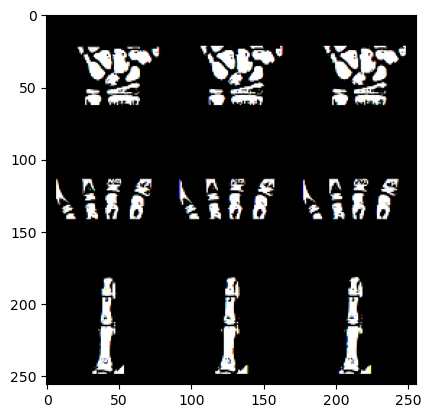

In [8]:
plt.imshow(X_data[0], 'gray')

### CNN 모델 생성 - Attention-Xception

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch

2024-02-03 14:44:23.973119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 14:44:23.973170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 14:44:23.974637: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 14:44:23.981712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 14:44:24.891280: W tensorflow/comp

In [10]:
#separable 합성곱 함수
def separable_conv(x, inchannel,outchannel):
  x = keras.layers.Conv2D(inchannel, (3,3), strides=1, padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(outchannel, (1,1), strides=1, padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  return x

In [11]:
#resiual_units 함수 
def resiual_units(input_x):
  x = keras.layers.ReLU()(input_x)
  x = separable_conv(x,x.shape[-1],128)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.ReLU()(x)
  x = separable_conv(x,x.shape[-1],256)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.ReLU()(x)
  x = separable_conv(x,x.shape[-1],512)
  x = keras.layers.BatchNormalization()(x)
  
  input_x = keras.layers.Add()([x,input_x])

  return input_x

In [12]:
#model middle_flow 함수
def middle_flow(input_x):
  #encoder
  x = keras.layers.MaxPool2D((2,2),padding="same")(input_x)
  x = resiual_units(x)
  x = keras.layers.MaxPool2D((2,2),padding="same")(x)
  x = resiual_units(x)
  x = keras.layers.MaxPool2D((2,2),padding="same")(x)
  x = resiual_units(x)
  
  #decoder
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  
  x = separable_conv(x,x.shape[-1],512)
  x = separable_conv(x,x.shape[-1],512) 
  
  #sigmoid 
  x = keras.activations.sigmoid(x)
  x = keras.layers.Multiply()([input_x,x])
  x = keras.layers.Add()([input_x,x])

  x = resiual_units(x)

  return x

In [13]:
#골연령 측정 모델
# entry flow model
input = keras.Input(shape=(256,256,1))
x = keras.layers.Conv2D(32, (3,3), strides = 2)(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Conv2D(64, (3,3), strides=1)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

#첫번째
x1 = keras.layers.Conv2D(128,(1,1),strides=2)(x) 
x1 = keras.layers.BatchNormalization()(x1)

x = separable_conv(x,x.shape[-1],128)
x = keras.layers.ReLU()(x)

x = separable_conv(x,x.shape[-1],128)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])

#2번째
x1 = keras.layers.Conv2D(512,(1,1),strides=2)(x)
x1 = keras.layers.BatchNormalization()(x1)

x = separable_conv(x,x.shape[-1],512)
x = keras.layers.ReLU()(x)

x = separable_conv(x,x.shape[-1],512)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])


#middle flow model
x = middle_flow(x)


#exit flow model
x1 = keras.layers.Conv2D(1024,(1,1),strides=2)(x)

x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],728)
x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],1024)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])


x = separable_conv(x,x.shape[-1],1536)
x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],2048)
x = keras.layers.ReLU()(x)

x = keras.layers.GlobalAvgPool2D()(x)

x = keras.layers.Dense(1000,activation='relu')(x)
x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dense(1)(x)

model = keras.models.Model(input,x)
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'], run_eagerly=True)

2024-02-03 14:44:26.873012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10691 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:5e:00.0, compute capability: 7.0


In [14]:
model.save('./tjnet_model.h5')

/home/aiuser/.conda/envs/junoflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 127, 127, 32)         0         ['batch_normalization[0][0

In [16]:
tmp = np.zeros((256,256))
for _, x in enumerate(X_data):
  if _ == 0:
    tmp = x[:, :, 0]
    tmp = tmp.reshape(1,256,256)
  else:
    tmp = np.concatenate([tmp,x[:, :, 0].reshape(1, 256, 256)])

X_data = tmp

In [19]:
# 8:1:1 == train:valid:test 
X_train, X_test, y_train, y_test = train_test_split(X_data.reshape(1237, 256, 256, -1), y_data, 
                                                  random_state=42, test_size=0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size = 0.5)

In [21]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

filename = 'checkpoint-50-epochs-16-batchs.h5'
checkpoint = ModelCheckpoint(filename, mointor='val_loss', verbose=1, 
                             save_best_only = True, mode='auto')

In [22]:
model.fit(X_train, y_train, batch_size=16, epochs=10, callbacks=checkpoint, validation_data=(X_val,y_val))

Epoch 1/10


2024-02-03 14:54:32.692672: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903
2024-02-03 14:54:50.784467: I external/local_xla/xla/service/service.cc:168] XLA service 0x2c0d8c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 14:54:50.784503: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2024-02-03 14:54:50.791087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706939690.907532 1437901 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 [==============================] - ETA: 0s - loss: 2.5645 - mae: 2.5645 - mse: 11.6381
Epoch 1: val_loss improved from inf to 12944.36719, saving model to checkpoint-50-epochs-16-batchs.h5


/home/aiuser/.conda/envs/junoflow/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


62/62 [==============================] - 99s 863ms/step - loss: 2.5645 - mae: 2.5645 - mse: 11.6381 - val_loss: 12944.3672 - val_mae: 12944.3672 - val_mse: 168902656.0000
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 1.6561 - mae: 1.6561 - mse: 4.5356
Epoch 2: val_loss improved from 12944.36719 to 390.86493, saving model to checkpoint-50-epochs-16-batchs.h5
62/62 [==============================] - 32s 515ms/step - loss: 1.6561 - mae: 1.6561 - mse: 4.5356 - val_loss: 390.8649 - val_mae: 390.8649 - val_mse: 155990.1562
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 1.6909 - mae: 1.6909 - mse: 4.6946
Epoch 3: val_loss improved from 390.86493 to 198.16812, saving model to checkpoint-50-epochs-16-batchs.h5
62/62 [==============================] - 32s 509ms/step - loss: 1.6909 - mae: 1.6909 - mse: 4.6946 - val_loss: 198.1681 - val_mae: 198.1681 - val_mse: 40483.2031
Epoch 4/10
62/62 [==============================] - ETA: 0s - loss: 1.5214 - mae: 1.

In [23]:
test_prediction = model.predict(X_test)
test_prediction

4/4 [==============================] - 23s 4s/step


array([[20.020245 ],
       [20.288963 ],
       [ 8.311853 ],
       [ 9.624403 ],
       [16.501926 ],
       [25.720707 ],
       [20.65457  ],
       [17.169277 ],
       [11.615506 ],
       [ 6.3342996],
       [10.886617 ],
       [ 8.446736 ],
       [15.688848 ],
       [ 8.669513 ],
       [14.484053 ],
       [14.762091 ],
       [ 8.637701 ],
       [ 7.984537 ],
       [18.849176 ],
       [ 7.011582 ],
       [ 9.822363 ],
       [17.408058 ],
       [ 4.621267 ],
       [ 5.643103 ],
       [ 5.7224374],
       [22.625942 ],
       [19.518904 ],
       [ 7.702126 ],
       [14.106095 ],
       [ 4.7615786],
       [20.281967 ],
       [18.492188 ],
       [16.141188 ],
       [ 6.2507105],
       [12.702396 ],
       [14.39802  ],
       [ 9.461072 ],
       [ 8.479868 ],
       [18.785603 ],
       [13.6404915],
       [ 7.6147456],
       [ 5.2921004],
       [18.381811 ],
       [10.153374 ],
       [20.21754  ],
       [20.401773 ],
       [ 6.2694445],
       [ 7.25

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('mae :', mean_absolute_error(test_prediction, y_test))
print('rmse :', np.sqrt(mean_squared_error(test_prediction, y_test)))

mae : 3.713782887304983
rmse : 4.141405693817993
